In [1]:
from time import perf_counter
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from sklearn.metrics import f1_score
import src.utils as utils
from src.model import MetMulDagma, MetMulColide

from baselines.colide import colide_ev
from baselines.dagma_linear import DAGMA_linear

FILE_PATH = "./datasets/sachs/"

## Auxiliary functions

In [2]:
def get_lamb_value(n_nodes, n_samples, times=1):
    return np.sqrt(np.log(n_nodes) / n_samples) * times 

def compute_errsW(W_seq, W_true):
    errs = np.zeros(len(W_seq))
    norm_W_true = np.linalg.norm(W_true)
    for i, W_est in enumerate(W_seq):
        errs[i] = (np.linalg.norm(W_true - W_est)/norm_W_true)**2
    
    return errs

def plot_convergence(model, W_true, leg=''):
    errs_W = compute_errsW(model.seq_W, W_true)
    plt.figure(figsize=(12, 4))
    plt.subplot(1,3,1)
    plt.semilogy(model.diff)
    plt.title(leg + ' - Convergence of W')
    plt.subplot(1,3,2)
    plt.semilogy(errs_W)
    plt.title(leg + ' - Error')
    plt.subplot(1,3,3)
    plt.semilogy(model.acyclicity)
    plt.title(leg + ' - Acyclicity')
    plt.tight_layout()

def run_exp(exps, W_true, X, X_std, n_nodes, n_samples, plot_conv=False):
    Ws_est = np.zeros((len(exps), n_nodes, n_nodes))
    times = np.zeros(len(exps))
    for i, exp in enumerate(exps):
        X_aux = X_std if 'standarize' in exp.keys() and exp['standarize'] else X

        arg_aux = exp['args'].copy()
        if 'adapt_lamb' in exp.keys() and exp['adapt_lamb']:
            if 'lamb' in exp['args'].keys():
                exp['args']['lamb'] = get_lamb_value(n_nodes, n_samples,arg_aux['lamb'])
            elif 'lambda1' in exp['args'].keys():
                exp['args']['lambda1'] = get_lamb_value(n_nodes, n_samples, arg_aux['lambda1'])

        if exp['model'] == MetMulDagma:
            arg_aux['track_seq'] = plot_conv


        model = exp['model'](**exp['init']) if 'init' in exp.keys() else exp['model']()
        t_init = perf_counter()
        model.fit(X_aux, **arg_aux)
        t_end = perf_counter()

        W_est = model.W_est
        if np.isnan(W_est).any():
            W_est = np.zeros_like(W_est)

        Ws_est[i] = W_est
        times[i] = t_end - t_init

        if plot_conv and exp['model'] == MetMulDagma:
            plot_convergence(model, W_true, exp['leg'])
    
    return Ws_est, times

def plot_dag_and_adj(dag, A, labels=None):
    # Plot gaph and adjacency with only strong edges
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    pos = nx.circular_layout(dag)
    nx.draw(dag, pos, with_labels=True, node_size=500, node_color='lightblue', arrowsize=15, ax=ax1)
    ax1.set_title("DAG")
    ax1.axis("off")

    im = ax2.imshow(A, cmap='Blues', interpolation='none')
    fig.colorbar(im, ax=ax2, label='Edge weight')

    if labels is not None:
        ax2.set_xticks(np.arange(len(labels)))
        ax2.set_yticks(np.arange(len(labels)))
        ax2.set_xticklabels(labels, rotation=90)
        ax2.set_yticklabels(labels)
    
    ax2.set_title("Adjacency (strong edges)")
    ax2.set_xlabel("Destiny")
    ax2.set_ylabel("Source")
    plt.tight_layout()
    plt.show()

def plot_results(exps, Ws_est, W_true, running_times, thr, plot):
    
    W_true_bin = utils.to_bin(W_true, thr)
    norm_W_true = np.linalg.norm(W_true)
    for i, exp in enumerate(exps):
        W_est = Ws_est[i]
        W_est_bin = utils.to_bin(W_est, thr)
        shd, tpr, fdr = utils.count_accuracy(W_true_bin, W_est_bin)
        fscore = f1_score(W_true_bin.flatten(), W_est_bin.flatten())
        err = utils.compute_norm_sq_err(W_true, W_est, norm_W_true)
        # acyc = model.dagness(W_est) if hasattr(model, 'dagness') else 1

        print(f"{exp['leg']}: SHD={shd} | TPR={tpr:.3f} | FDR={fdr:.3f} | F1={fscore:.3f} | Err={err:.3f} | Time={running_times[i]:.2f}s")

        if plot:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
            im1 = ax1.imshow(W_true, cmap='Blues', interpolation='none')
            ax1.set_title("W true")
            fig.colorbar(im1, ax=ax1)
            im2 = ax2.imshow(W_est, cmap='Blues', interpolation='none')
            ax2.set_title("W_est - " + exp['leg'])
            fig.colorbar(im2, ax=ax2)

## Load and plot data

11 nodes, 853 samples
2.2580974682540975
0.01


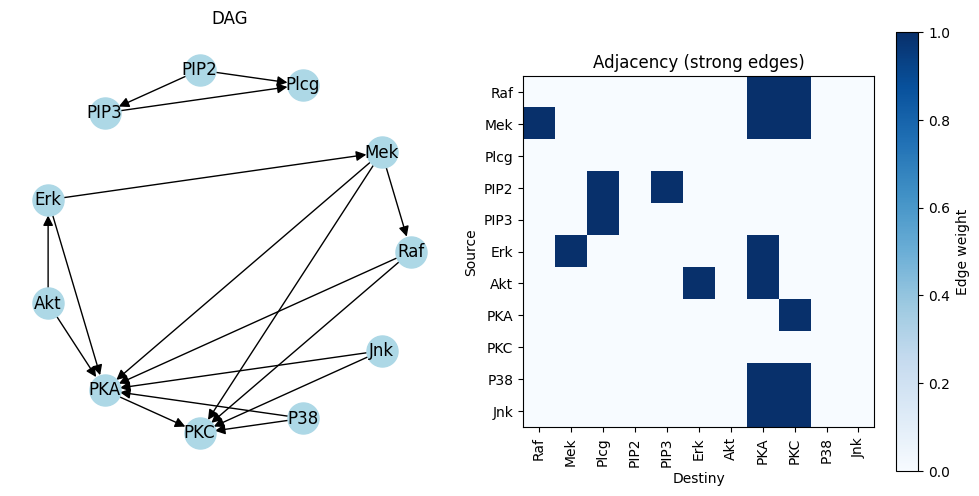

In [3]:
X = np.load(FILE_PATH + "sachs_X.npy")
node_order = np.load(FILE_PATH + "node_order.npy")
W = np.load(FILE_PATH + "sachs_A_matrix.npy")
W_all = np.load(FILE_PATH + "sachs_A_matrix_all.npy")

X_std = utils.standarize(X)

n_samples, n_nodes = X.shape

print(f"{n_nodes} nodes, {n_samples} samples")

print(np.linalg.norm(X)/np.sqrt(n_samples * n_nodes)*.01)
print(np.linalg.norm(X_std)/np.sqrt(n_samples * n_nodes)*.01)

dag = nx.DiGraph(W)
dag = nx.relabel_nodes(dag, dict(enumerate(node_order)))

plot_dag_and_adj(dag, W, labels=node_order)


MM-PGD-std: SHD=11 | TPR=0.353 | FDR=0.000 | F1=0.522 | Err=0.898 | Time=34.12s
MM-Logdet-std: SHD=14 | TPR=0.176 | FDR=0.400 | F1=0.273 | Err=1.438 | Time=2.21s
MM-Fista-std: SHD=11 | TPR=0.353 | FDR=0.000 | F1=0.522 | Err=0.952 | Time=1.51s
MM-Fista-std-low_err: SHD=17 | TPR=0.000 | FDR=0.000 | F1=0.000 | Err=0.843 | Time=3.89s
MM-Fista-std-low_shd_resc: SHD=15 | TPR=0.118 | FDR=0.000 | F1=0.211 | Err=0.839 | Time=0.18s
MM-Fista-std-NEW: SHD=17 | TPR=0.000 | FDR=0.000 | F1=0.000 | Err=0.800 | Time=0.15s
MM-Col-fista-r: SHD=27 | TPR=0.294 | FDR=0.792 | F1=0.244 | Err=1.592 | Time=27.62s
MM-Col-sca: SHD=31 | TPR=0.294 | FDR=0.828 | F1=0.217 | Err=1.381 | Time=6.21s
MM-Col-fista-r-std: SHD=15 | TPR=0.176 | FDR=0.400 | F1=0.273 | Err=1.555 | Time=6.56s
MM-Col-sca-std: SHD=15 | TPR=0.118 | FDR=0.500 | F1=0.190 | Err=1.640 | Time=1.67s
CoLiDe-Fix: SHD=16 | TPR=0.412 | FDR=0.650 | F1=0.378 | Err=1.984 | Time=5.62s
CoLiDe-Fix-std: SHD=15 | TPR=0.118 | FDR=0.667 | F1=0.174 | Err=1.445 | Time=

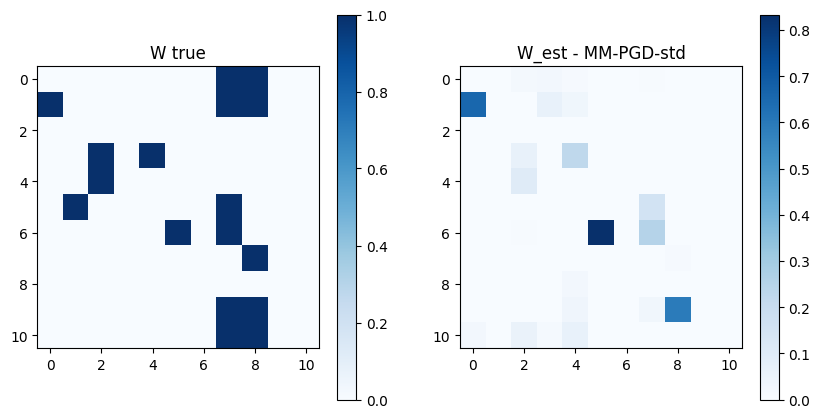

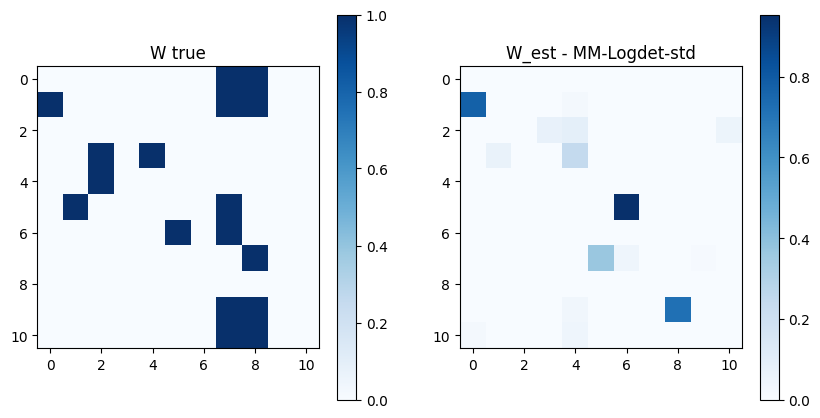

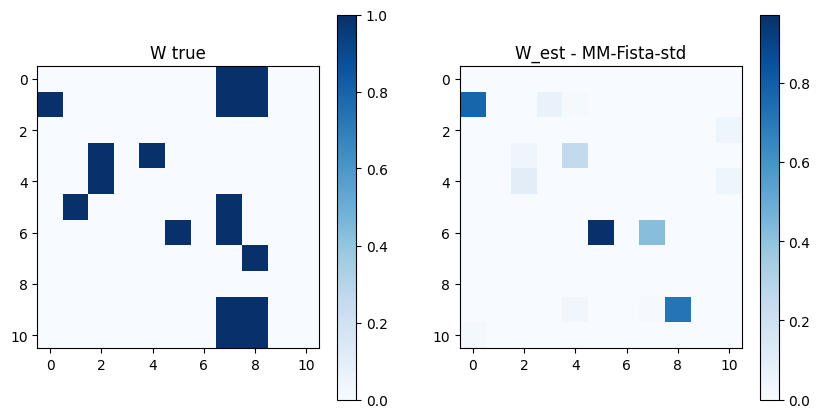

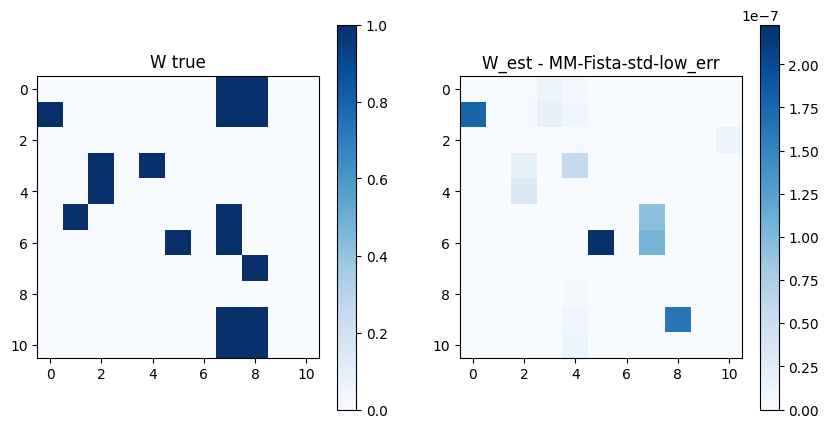

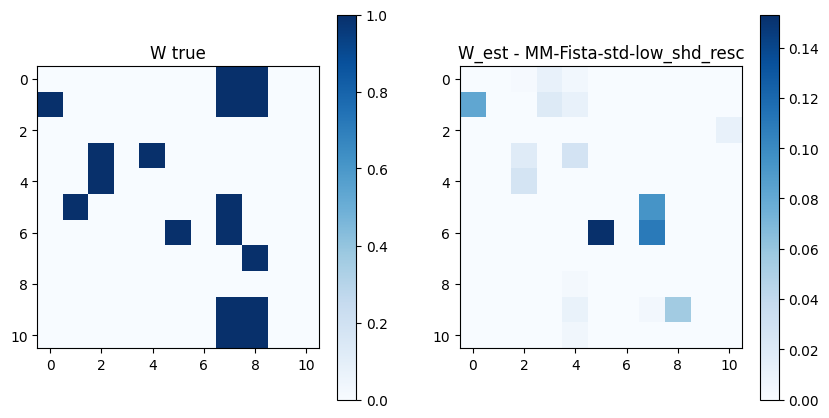

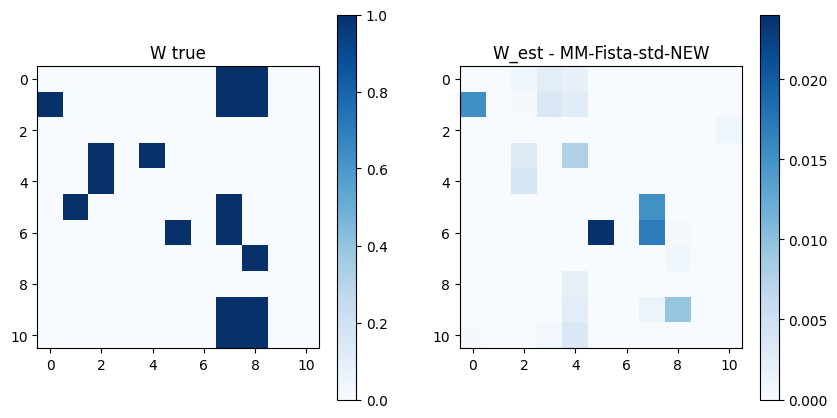

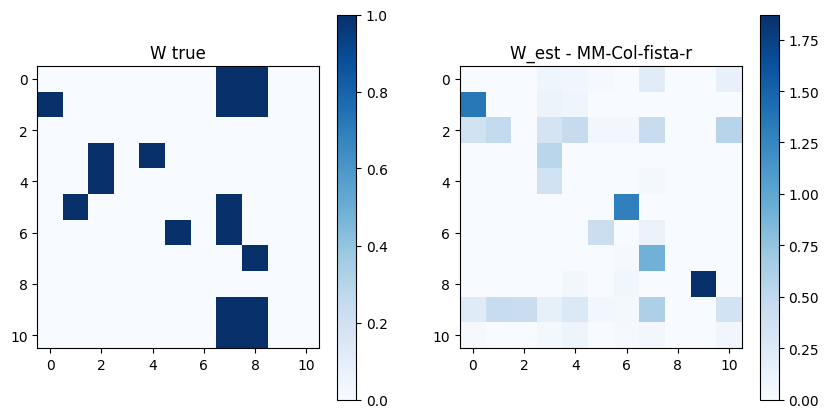

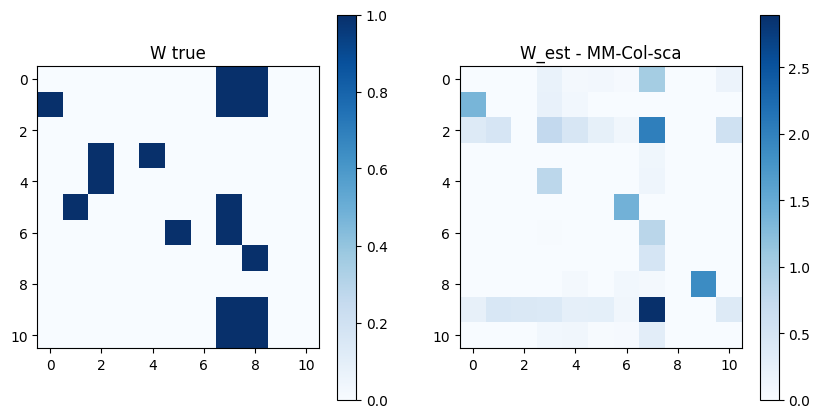

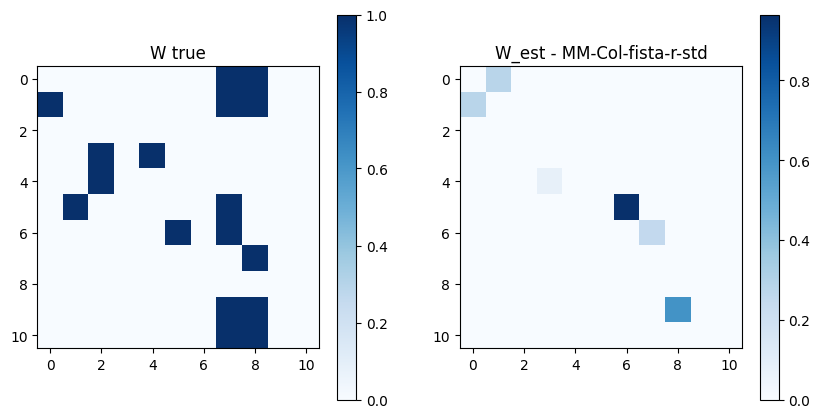

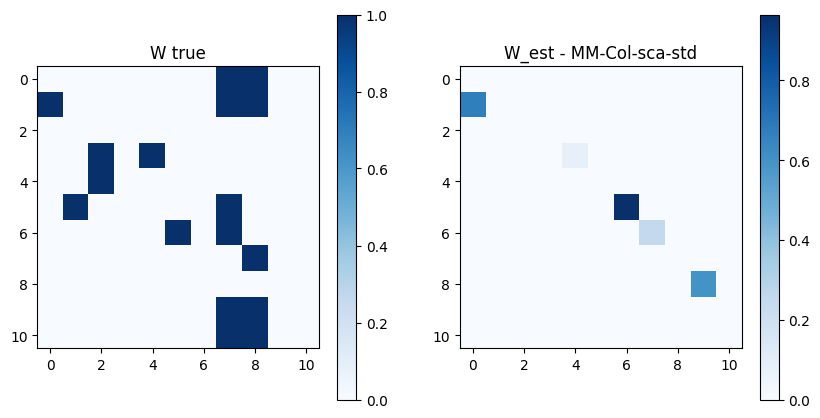

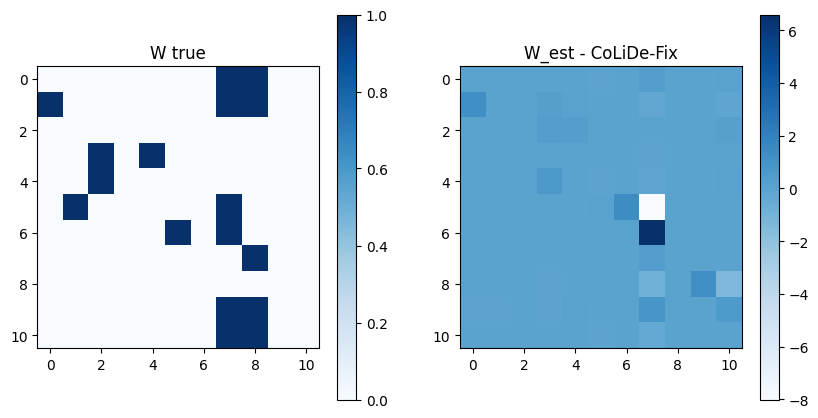

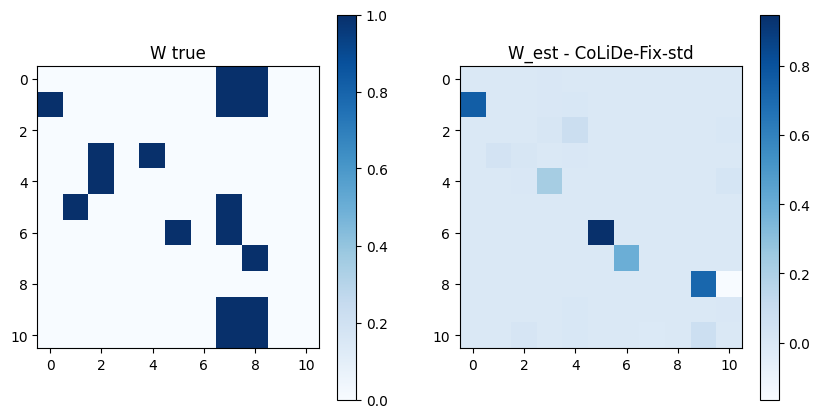

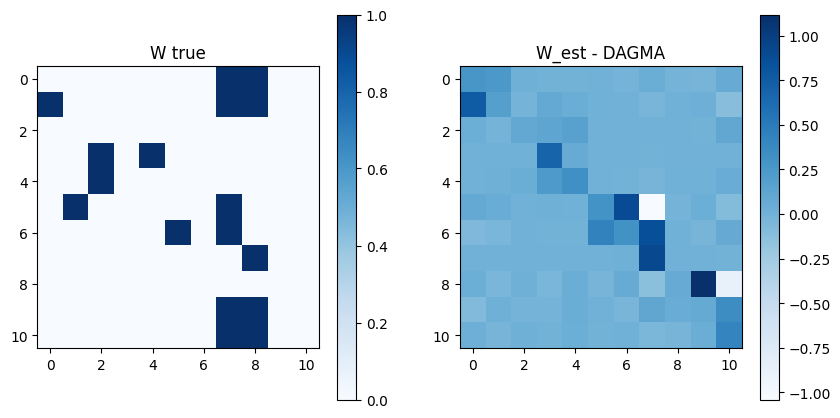

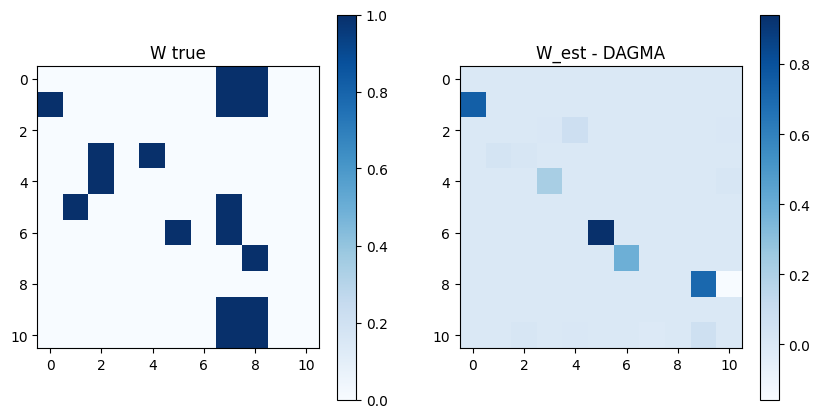

In [4]:
thr = .1
plot_W = True
plot_conv = False

Exps = [
  {'model': MetMulDagma, 'args': {'stepsize': 1e-5, 'alpha_0': .1, 'rho_0': 5, 's': 1, 'lamb': 1e-4,
   'iters_in': 10000, 'iters_out': 50, 'beta': 1.2, 'Sigma':1}, 'init': {'primal_opt': 'pgd', 'acyclicity': 'logdet'},
   'adapt_lamb': False, 'standarize': True, 'fmt': 'o-', 'leg': 'MM-PGD-std'},
   
  # {'model': MetMulDagma, 'args': {'stepsize': 1e-5, 'alpha_0': .1, 'rho_0': 5, 's': 1, 'lamb': 1e-4,
  #  'iters_in': 10000, 'iters_out': 50, 'beta': 1.2, 'Sigma':1}, 'init': {'primal_opt': 'adam', 'acyclicity': 'logdet'},
  #  'adapt_lamb': False, 'standarize': True, 'fmt': 'o-', 'leg': 'MM-Logdet-std'},

  # {'model': MetMulDagma, 'args': {'stepsize': 1e-5, 'alpha_0': .1, 'rho_0': 5, 's': 1, 'lamb': 1e-4,
  #  'iters_in': 10000, 'iters_out': 50, 'beta': 1.2, 'Sigma':1}, 'init': {'primal_opt': 'fista', 'acyclicity': 'logdet', 'restart': True},
  #  'adapt_lamb': False, 'standarize': True, 'fmt': 'o-', 'leg': 'MM-Fista-std'},

  # # Faster
  # {'model': MetMulDagma, 'args': {'stepsize': 5e-5, 'alpha_0': .1, 'rho_0': 5, 's': .8, 'lamb': 1e-2,
  #  'iters_in': 10000, 'iters_out': 50, 'beta': 1.2, 'Sigma': 1}, 'init': {'primal_opt': 'pgd', 'acyclicity': 'logdet'},
  #  'adapt_lamb': False, 'standarize': True, 'fmt': 'o-', 'leg': 'MM-PGD-std'},
  
  {'model': MetMulDagma, 'args': {'stepsize': 5e-5, 'alpha_0': .1, 'rho_0': 5, 's': .8, 'lamb': 1e-2,
   'iters_in': 10000, 'iters_out': 50, 'beta': 1.2, 'Sigma': 1}, 'init': {'primal_opt': 'adam', 'acyclicity': 'logdet'},
   'adapt_lamb': False, 'standarize': True, 'fmt': 'o-', 'leg': 'MM-Logdet-std'},

  {'model': MetMulDagma, 'args': {'stepsize': 5e-5, 'alpha_0': .1, 'rho_0': 5, 's': .8, 'lamb': 1e-2,
   'iters_in': 10000, 'iters_out': 50, 'beta': 1.2, 'Sigma': 1}, 'init': {'primal_opt': 'fista', 'acyclicity': 'logdet', 'restart': True},
   'adapt_lamb': False, 'standarize': True, 'fmt': 'o-', 'leg': 'MM-Fista-std'},

  # The ones needing reescaling
  {'model': MetMulDagma, 'args': {'stepsize': 1e-5, 'alpha_0': .1, 'rho_0': 1, 's': .5, 'lamb': 1e-2,
   'iters_in': 10000, 'iters_out': 100, 'beta': 5, 'Sigma': 1}, 'init': {'primal_opt': 'fista', 'acyclicity': 'logdet', 'restart': True},
   'adapt_lamb': False, 'standarize': True, 'fmt': 'o-', 'leg': 'MM-Fista-std-low_err'},
  
  {'model': MetMulDagma, 'args': {'stepsize': 1e-5, 'alpha_0': .1, 'rho_0': 1, 's': .5, 'lamb': 1e-2,
   'iters_in': 500, 'iters_out': 5, 'beta': 5, 'Sigma': 1}, 'init': {'primal_opt': 'fista', 'acyclicity': 'logdet', 'restart': True},
   'adapt_lamb': False, 'standarize': True, 'fmt': 'o-', 'leg': 'MM-Fista-std-low_shd_resc'},


  {'model': MetMulDagma, 'args': {'stepsize': 1e-5, 'alpha_0': .1, 'rho_0': 5, 's': .8, 'lamb': 1e-3,
   'iters_in': 100, 'iters_out': 20, 'beta': 2, 'Sigma': 1}, 'init': {'primal_opt': 'fista', 'acyclicity': 'logdet', 'restart': True},
   'adapt_lamb': False, 'standarize': True, 'fmt': 'o-', 'leg': 'MM-Fista-std-NEW'},

  # CVX CoLiDE
  {'model': MetMulColide, 'args': {'stepsize': 5e-5, 'alpha_0': .1, 'rho_0': .1, 's': 1, 'lamb': .1, 'iters_in': 30000,
     'iters_out': 10, 'beta': 1.2}, 'init': {'acyclicity': 'logdet', 'primal_opt': 'fista', 'restart': True}, 'standarize': False,
     'adapt_lamb': True, 'leg': 'MM-Col-fista-r'},
  
  {'model': MetMulColide, 'args': {'stepsize': 3e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': .1, 'iters_in': 20000,
     'iters_out': 10, 'beta': 2, 'sca_adam': True}, 'init': {'acyclicity': 'logdet', 'primal_opt': 'sca'}, 'standarize': False,
     'adapt_lamb': True, 'leg': 'MM-Col-sca'},

  {'model': MetMulColide, 'args': {'stepsize': 5e-5, 'alpha_0': .1, 'rho_0': .1, 's': 1, 'lamb': .1, 'iters_in': 30000,
     'iters_out': 10, 'beta': 1.2}, 'init': {'acyclicity': 'logdet', 'primal_opt': 'fista', 'restart': True}, 'standarize': True,
     'adapt_lamb': True, 'leg': 'MM-Col-fista-r-std'},
  
  {'model': MetMulColide, 'args': {'stepsize': 3e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': .1, 'iters_in': 20000,
     'iters_out': 10, 'beta': 2, 'sca_adam': True}, 'init': {'acyclicity': 'logdet', 'primal_opt': 'sca'}, 'standarize': True,
     'adapt_lamb': True, 'leg': 'MM-Col-sca-std'},

  # Colide
  {'model': colide_ev, 'args': {'lambda1': .05, 'T': 4, 's': [1.0, .9, .8, .7], 'warm_iter': 2e4,
   'max_iter': 7e4, 'lr': .0003}, 'standarize': False, 'fmt': 'v--', 'leg': 'CoLiDe-Fix'},
  
  {'model': colide_ev, 'args': {'lambda1': .05, 'T': 4, 's': [1.0, .9, .8, .7], 'warm_iter': 2e4,
   'max_iter': 7e4, 'lr': .0003}, 'standarize': True, 'fmt': 'v--', 'leg': 'CoLiDe-Fix-std'},

  # DAGMA
  {'model': DAGMA_linear, 'init': {'loss_type': 'l2'}, 'args': {'lambda1': .05, 'T': 4, 's': [1.0, .9, .8, .8],
   'warm_iter': 2e4, 'max_iter': 7e4, 'lr': .0003}, 'standarize': False, 'fmt': '^-', 'leg': 'DAGMA'},
  
  {'model': DAGMA_linear, 'init': {'loss_type': 'l2'}, 'args': {'lambda1': .05, 'T': 4, 's': [1.0, .9, .8, .8],
   'warm_iter': 2e4, 'max_iter': 7e4, 'lr': .0003}, 'standarize': True, 'fmt': '^-', 'leg': 'DAGMA'},
]

Ws_est, running_times = run_exp(Exps, W, X, X_std, n_nodes, n_samples, plot_conv)
plot_results(Exps, Ws_est, W, running_times, thr, plot_W)


In [5]:
plot_results(Exps, Ws_est, W, running_times, .2, False)

MM-PGD-std: SHD=12 | TPR=0.294 | FDR=0.000 | F1=0.455 | Err=0.898 | Time=34.12s
MM-Logdet-std: SHD=14 | TPR=0.176 | FDR=0.400 | F1=0.273 | Err=1.438 | Time=2.21s
MM-Fista-std: SHD=12 | TPR=0.294 | FDR=0.000 | F1=0.455 | Err=0.952 | Time=1.51s
MM-Fista-std-low_err: SHD=17 | TPR=0.000 | FDR=0.000 | F1=0.000 | Err=0.843 | Time=3.89s
MM-Fista-std-low_shd_resc: SHD=17 | TPR=0.000 | FDR=0.000 | F1=0.000 | Err=0.839 | Time=0.18s
MM-Fista-std-NEW: SHD=17 | TPR=0.000 | FDR=0.000 | F1=0.000 | Err=0.800 | Time=0.15s
MM-Col-fista-r: SHD=25 | TPR=0.235 | FDR=0.800 | F1=0.216 | Err=1.592 | Time=27.62s
MM-Col-sca: SHD=27 | TPR=0.294 | FDR=0.800 | F1=0.238 | Err=1.381 | Time=6.21s
MM-Col-fista-r-std: SHD=15 | TPR=0.176 | FDR=0.400 | F1=0.273 | Err=1.555 | Time=6.56s
MM-Col-sca-std: SHD=15 | TPR=0.118 | FDR=0.500 | F1=0.190 | Err=1.640 | Time=1.67s
CoLiDe-Fix: SHD=13 | TPR=0.412 | FDR=0.588 | F1=0.412 | Err=1.984 | Time=5.62s
CoLiDe-Fix-std: SHD=15 | TPR=0.118 | FDR=0.600 | F1=0.182 | Err=1.445 | Time=

In [6]:
def rescale_plot_results(exps, Ws_est, W_true, running_times, thr, plot):
    
    W_true_bin = utils.to_bin(W_true, thr)
    norm_W_true = np.linalg.norm(W_true)
    for i, exp in enumerate(exps):
        W_est = Ws_est[i]

        W_est /= np.max(np.abs(W_est))

        W_est_bin = utils.to_bin(W_est, thr)
        shd, tpr, fdr = utils.count_accuracy(W_true_bin, W_est_bin)
        fscore = f1_score(W_true_bin.flatten(), W_est_bin.flatten())
        err = utils.compute_norm_sq_err(W_true, W_est, norm_W_true)
        # acyc = model.dagness(W_est) if hasattr(model, 'dagness') else 1

        print(f"{exp['leg']}: SHD={shd} | TPR={tpr:.3f} | FDR={fdr:.3f} | F1={fscore:.3f} | Err={err:.3f} | Time={running_times[i]:.2f}s")

        if plot:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
            im1 = ax1.imshow(W_true, cmap='Blues', interpolation='none')
            ax1.set_title("W true")
            fig.colorbar(im1, ax=ax1)
            im2 = ax2.imshow(W_est, cmap='Blues', interpolation='none')
            ax2.set_title("W_est - " + exp['leg'])
            fig.colorbar(im2, ax=ax2)

rescale_plot_results(Exps, Ws_est, W, running_times, .1, False)

MM-PGD-std: SHD=10 | TPR=0.412 | FDR=0.000 | F1=0.583 | Err=0.898 | Time=34.12s
MM-Logdet-std: SHD=14 | TPR=0.176 | FDR=0.400 | F1=0.273 | Err=1.438 | Time=2.21s
MM-Fista-std: SHD=11 | TPR=0.353 | FDR=0.000 | F1=0.522 | Err=0.952 | Time=1.51s
MM-Fista-std-low_err: SHD=10 | TPR=0.412 | FDR=0.000 | F1=0.583 | Err=0.843 | Time=3.89s
MM-Fista-std-low_shd_resc: SHD=10 | TPR=0.471 | FDR=0.111 | F1=0.615 | Err=0.839 | Time=0.18s
MM-Fista-std-NEW: SHD=14 | TPR=0.471 | FDR=0.385 | F1=0.533 | Err=0.800 | Time=0.15s
MM-Col-fista-r: SHD=25 | TPR=0.235 | FDR=0.800 | F1=0.216 | Err=1.592 | Time=27.62s
MM-Col-sca: SHD=21 | TPR=0.294 | FDR=0.737 | F1=0.278 | Err=1.381 | Time=6.21s
MM-Col-fista-r-std: SHD=15 | TPR=0.176 | FDR=0.400 | F1=0.273 | Err=1.555 | Time=6.56s
MM-Col-sca-std: SHD=15 | TPR=0.118 | FDR=0.500 | F1=0.190 | Err=1.640 | Time=1.67s
CoLiDe-Fix: SHD=14 | TPR=0.176 | FDR=0.571 | F1=0.250 | Err=1.984 | Time=5.62s
CoLiDe-Fix-std: SHD=15 | TPR=0.118 | FDR=0.667 | F1=0.174 | Err=1.445 | Time=

In [7]:
plot_results(Exps, Ws_est, W_all, running_times, .1, False)

MM-PGD-std: SHD=13 | TPR=0.350 | FDR=0.000 | F1=0.519 | Err=0.984 | Time=34.12s
MM-Logdet-std: SHD=17 | TPR=0.150 | FDR=0.400 | F1=0.240 | Err=1.482 | Time=2.21s
MM-Fista-std: SHD=14 | TPR=0.300 | FDR=0.000 | F1=0.462 | Err=1.034 | Time=1.51s
MM-Fista-std-low_err: SHD=13 | TPR=0.350 | FDR=0.000 | F1=0.519 | Err=0.933 | Time=3.89s
MM-Fista-std-low_shd_resc: SHD=13 | TPR=0.400 | FDR=0.111 | F1=0.552 | Err=0.930 | Time=0.18s
MM-Fista-std-NEW: SHD=17 | TPR=0.400 | FDR=0.385 | F1=0.485 | Err=0.894 | Time=0.15s
MM-Col-fista-r: SHD=28 | TPR=0.200 | FDR=0.800 | F1=0.200 | Err=1.624 | Time=27.62s
MM-Col-sca: SHD=24 | TPR=0.250 | FDR=0.737 | F1=0.256 | Err=1.429 | Time=6.21s
MM-Col-fista-r-std: SHD=18 | TPR=0.150 | FDR=0.400 | F1=0.240 | Err=1.589 | Time=6.56s
MM-Col-sca-std: SHD=18 | TPR=0.100 | FDR=0.500 | F1=0.167 | Err=1.668 | Time=1.67s
CoLiDe-Fix: SHD=17 | TPR=0.150 | FDR=0.571 | F1=0.222 | Err=1.989 | Time=5.62s
CoLiDe-Fix-std: SHD=18 | TPR=0.100 | FDR=0.667 | F1=0.154 | Err=1.488 | Time=